# Вариант 12
### 5/2,4
### Титаник
1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
7.	Заполните пропущенные значения в данных;
8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 
9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.


### Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

1. survival: выживание(0-нет, 1-да)
2. pclass: класс билета(1, 2, 3)
3. name: имя
4. sex: пол(female - женский, male - мужской)
5. age: возраст
6. sibsp: число братьев/сестер/супруг на борту
7. parch: чило родителей/детей на борту
8. ticket: номер билета
9. fare: цена билета
10. cabin: номер комнаты
11. embarked: порт(C = Cherbourg, Q = Queenstown, S = Southampton)
12. boat: номер лодки
13. body: номер тела
14. home.dest: дом-назначение

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [224]:
titanic = pd.read_csv('titanic3.csv', sep = ';', comment = '#', decimal=',')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [225]:
print("До удаления дубликатов: ", titanic.shape)
titanic.drop_duplicates(keep='first',inplace = True)
print("После удаления: ", titanic.shape)

До удаления дубликатов:  (1309, 14)
После удаления:  (1309, 14)


### Оцените сбалансированность данных по классам . Используйте полученную информацию при выборе метрики оценки качества классификации

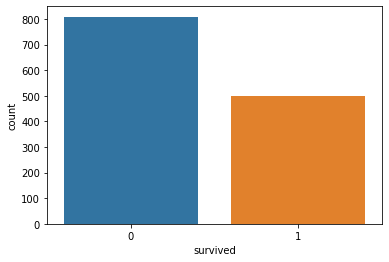

In [167]:
sns.countplot(data = titanic, x='survived')

### Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [226]:
#нужно убрать несколько столбцов 
titanic = titanic.drop(['name','ticket', 'body', 'cabin', 'home.dest', 'boat'], axis=1)
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


numerical:  ['age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'survived', 'sex', 'embarked']


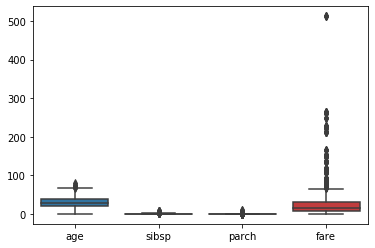

In [227]:
#выделим категориальные и числовые признаки
columns = titanic.columns

#survived и pclass должны быть категориальными
numerical = [i for i in columns if titanic[i].dtype.name != 'object'
                                     and i != 'pclass' and i != 'survived']
categorical = [i for i in columns if titanic[i].dtype.name == 'object' 
                                      or i == 'pclass' or i == 'survived']
print('numerical: ', numerical)
print('categorial: ', categorical)

sns.boxplot(data = titanic[numerical])

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,0.361169,0.000,0.000000,0.412503,S
1,1,1,male,0.009395,0.125,0.222222,0.295806,S
2,1,0,female,0.022964,0.125,0.222222,0.295806,S
3,1,0,male,0.373695,0.125,0.222222,0.295806,S
4,1,0,female,0.311064,0.125,0.222222,0.295806,S
...,...,...,...,...,...,...,...,...
1304,3,0,female,0.179540,0.125,0.000000,0.028213,C
1305,3,0,female,NaN,0.125,0.000000,0.028213,C
1306,3,0,male,0.329854,0.000,0.000000,0.014102,C
1307,3,0,male,0.336117,0.000,0.000000,0.014102,C


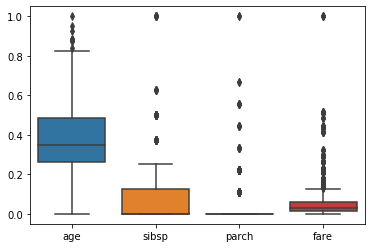

In [170]:
scaler = preprocessing.MinMaxScaler()

titanic[numerical] = scaler.fit_transform(titanic[numerical].values.astype(float))
sns.boxplot(data=titanic[numerical])

titanic

### Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [171]:
#нужно разделить категориальные признаки на бинарные и небинарные
binary = [c for c in categorical if len(titanic[c].unique()) == 2]
nonbinary = [c for c in categorical if len(titanic[c].unique()) > 2]
print('Бинарные: ', binary)
print('Небинарные: ', nonbinary)

Бинарные:  ['survived', 'sex']
Небинарные:  ['pclass', 'embarked']


In [172]:
#Меняем значения для бинарных признаков
titanic.at[titanic['sex'] == 'male', 'sex'] = 1
titanic.at[titanic['sex'] == 'female', 'sex'] = 0
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,0.361169,0.000,0.000000,0.412503,S
1,1,1,1,0.009395,0.125,0.222222,0.295806,S
2,1,0,0,0.022964,0.125,0.222222,0.295806,S
3,1,0,1,0.373695,0.125,0.222222,0.295806,S
4,1,0,0,0.311064,0.125,0.222222,0.295806,S


In [173]:
#для небинарных
df_nonbinary = pd.get_dummies(titanic[nonbinary])
#удалим старыые колонки
titanic.drop(nonbinary, axis=1, inplace=True)
#добавим новые
titanic = pd.concat([titanic, df_nonbinary], axis=1)

In [174]:
titanic.head()

,survived,sex,age,sibsp,parch,fare,pclass,embarked_C,embarked_Q,embarked_S
0,1,0,0.361169,0.000,0.000000,0.412503,1,0,0,1
1,1,1,0.009395,0.125,0.222222,0.295806,1,0,0,1
2,0,0,0.022964,0.125,0.222222,0.295806,1,0,0,1
3,0,1,0.373695,0.125,0.222222,0.295806,1,0,0,1
4,0,0,0.311064,0.125,0.222222,0.295806,1,0,0,1


### Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

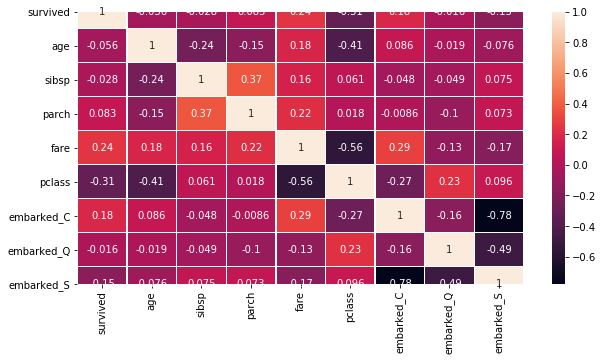

In [175]:
plt.figure(figsize=(10,5))
sns.heatmap(titanic.corr(), annot = True, linewidths=.5)

### Заполните пропущенные значения в данных

In [176]:
titanic.count()

survived      1309
sex           1309
age           1046
sibsp         1309
parch         1309
fare          1308
pclass        1309
embarked_C    1309
embarked_Q    1309
embarked_S    1309
dtype: int64

In [177]:
titanic = titanic.fillna(titanic.median(axis=0), axis=0)
titanic.count()

survived      1309
sex           1309
age           1309
sibsp         1309
parch         1309
fare          1309
pclass        1309
embarked_C    1309
embarked_Q    1309
embarked_S    1309
dtype: int64

### Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

###### классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов)

In [178]:
X, y = titanic.drop(('survived'), axis=1), titanic['survived']
feature_names = X.columns
print(feature_names)

Index(['sex', 'age', 'sibsp', 'parch', 'fare', 'pclass', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

916 393


In [180]:
rnc = RadiusNeighborsClassifier()
params = {'radius': [2, 3, 4],
          'weights': ['uniform', 'distance']}

In [181]:
rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RadiusNeighborsClassifier(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None,
                                                 outlier_label=None, p=2,
                                                 radius=1.0,
                                                 weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'radius': [2, 3, 4],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [182]:
r = rnc_grid.best_estimator_.radius
rnc = RadiusNeighborsClassifier(radius=r)
rnc.fit(X_train, y_train)
y_score = rnc.predict(X_test)
print('Best: %.7f'%(rnc_grid.best_score_))

Best: 0.7707947


###### логический классификатор (бинарное решающее дерево)

In [188]:
tree = DecisionTreeClassifier()
X, y = titanic.drop(('survived'), axis=1), titanic['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)
params = {'max_depth': list(range(1, 12))}

In [189]:
tree_grid = GridSearchCV(tree, params)
tree_grid.fit (X_train, y_train)

best_features = tree_grid.best_estimator_.max_features
best_depth = tree_grid.best_estimator_.max_depth
best_score = tree_grid.best_score_
print('лучший тренировочный результат:', best_score, 
      '\t глубина:', best_depth)

tree = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
tree.fit(X_train, y_train)
best_score  = np.mean(y_test == tree.predict(X_test))
print('лучший результат: ', best_score)

лучший тренировочный результат: 0.8111427892611072 	 глубина: 3
лучший результат:  0.816793893129771


###### PR

In [190]:
rnc_proba = rnc.predict_proba(X_test)
tree_proba = tree.predict_proba(X_test)

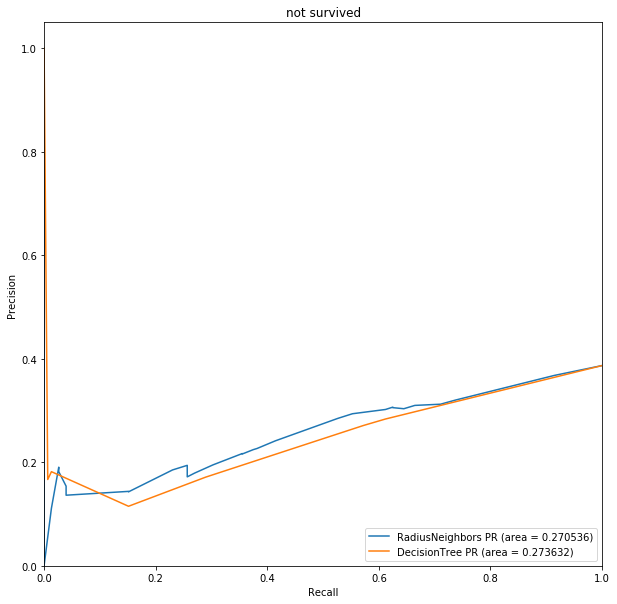

In [218]:
plt.figure(figsize=(10,10))
#соседи
precision, recall, _ = precision_recall_curve(y_test, rnc_proba[:, 0])
aps = average_precision_score(y_test, rnc_proba[:, 0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighbors', aps))
#дерево решений
precision, recall, _ = precision_recall_curve(y_test, tree_proba[:, 0])
aps = average_precision_score(y_test, tree_proba[:, 0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTree', aps))
#график
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('not survived')
plt.legend(loc=4, fontsize='medium')
plt.show()

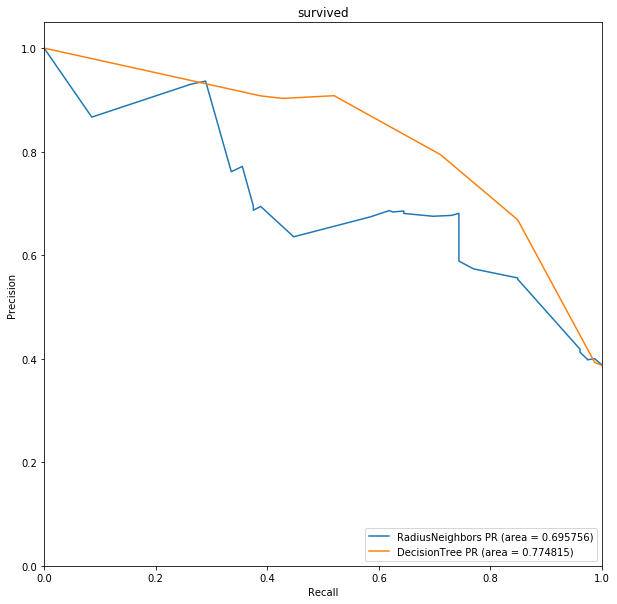

In [222]:
plt.figure(figsize=(10,10))

#соседи
precision, recall, _ = precision_recall_curve(y_test, rnc_proba[:, 1])
aps = average_precision_score(y_test, rnc_proba[:, 1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighbors', aps))
#дерево решений
precision, recall, _ = precision_recall_curve(y_test, tree_proba[:, 1])
aps = average_precision_score(y_test, tree_proba[:, 1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTree', aps))
#график
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('survived')
plt.legend(loc=4, fontsize='medium')
plt.show()

###### ROC

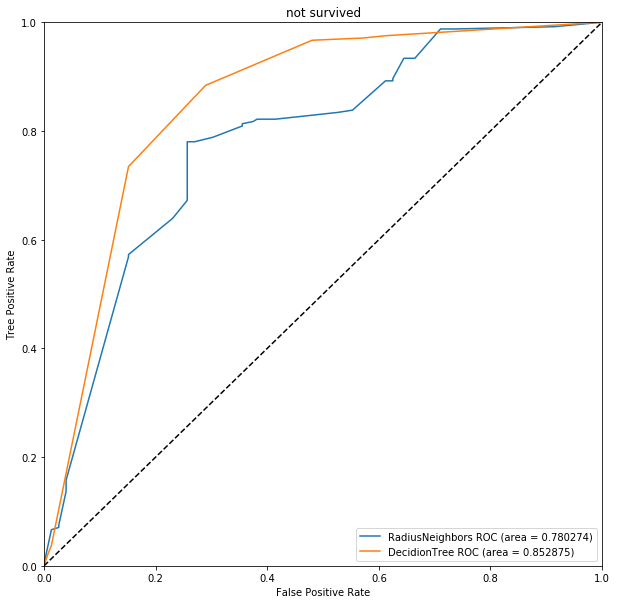

In [220]:
plt.figure(figsize=(10,10))

#соседи
tpr, fpr, _ = roc_curve(y_test, rnc_proba[:, 0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighbors', roc_auc))
#дерево решений
tpr, fpr, _ = roc_curve(y_test, tree_proba[:, 0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecidionTree', roc_auc))
#график
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('Tree Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('not survived')
plt.show()

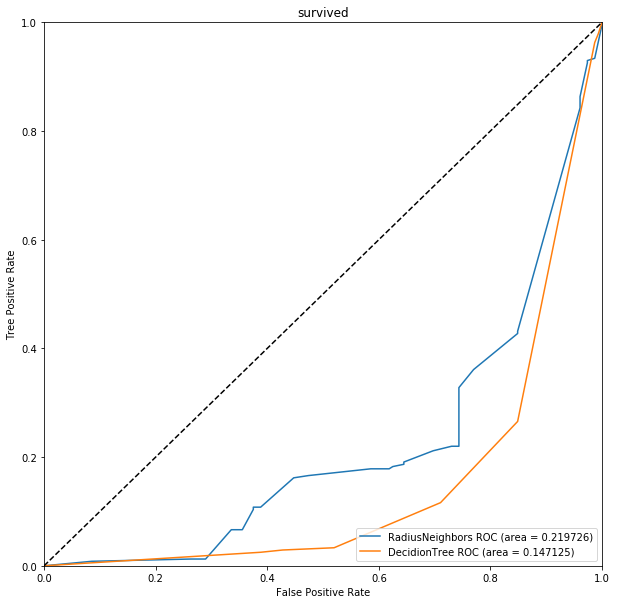

In [221]:
plt.figure(figsize=(10,10))

#соседи
tpr, fpr, _ = roc_curve(y_test, rnc_proba[:, 1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighbors', roc_auc))
#дерево решений
tpr, fpr, _ = roc_curve(y_test, tree_proba[:, 1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecidionTree', roc_auc))
#график
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('Tree Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

Вывод: логический классификатор работает лучше 